# LDA 
[Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is a technique by which data is separated into topics using Bayesian statistics. This notebook uses the Amazon reviews dataset and trials sentiment analysis, using the topics discovered in LDA, using 3 different architectures.

In [48]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from gensim import corpora, models
from pprint import pprint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM, SimpleRNN
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import random


In [ ]:
data = pd.read_csv("data/Reviews.csv")
data_text = pd.DataFrame(data["Text"])
data_text['index'] = data_text.index
data_text.head()
stemmer = SnowballStemmer('english')

In [2]:
len(data_text)

568454

In [3]:
def lemmatize_and_stem(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos = 'v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_and_stem(token))
    return result

In [4]:
processed_docs = data_text["Text"].map(preprocess)
processed_docs[:5]

0    [buy, vital, can, food, product, good, qualiti...
1    [product, arriv, label, jumbo, salt, peanut, p...
2    [confect, centuri, light, pillowi, citrus, gel...
3    [look, secret, ingredi, robitussin, believ, ad...
4    [great, taffi, great, price, wide, assort, yum...
Name: Text, dtype: object

In [5]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [52]:
def visualise_topics(model, topics):
    print(topics)
    for topic in range(0, topics):
        text = ""
        topic_terms = model.get_topic_terms(topic)
        for topic_term in topic_terms:
            text += " "
            text+= " ".join([dictionary[topic_term[0]] for i in range(int(topic_term[1]*1000))])
        wc = WordCloud(background_color='white', max_words=1000, margin=10,
               random_state=1).generate(text)
        plt.title("Topic {}".format(topic))
        plt.imshow(wc.recolor(random_state=3),
               interpolation="bilinear")
        plt.figure()

## Bag of Words

In [7]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[:2]

[[(0, 1),
  (1, 2),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 3),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1)],
 [(12, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 2),
  (22, 1),
  (23, 2),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1)]]

In [8]:
bow_doc_0 = bow_corpus[0]

for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], 
                                                     dictionary[bow_doc_0[i][0]], 
                                                     bow_doc_0[i][1]))

Word 0 ("appreci") appears 1 time.
Word 1 ("better") appears 2 time.
Word 2 ("buy") appears 1 time.
Word 3 ("can") appears 1 time.
Word 4 ("finicki") appears 1 time.
Word 5 ("food") appears 1 time.
Word 6 ("good") appears 1 time.
Word 7 ("labrador") appears 1 time.
Word 8 ("like") appears 1 time.
Word 9 ("look") appears 1 time.
Word 10 ("meat") appears 1 time.
Word 11 ("process") appears 1 time.
Word 12 ("product") appears 3 time.
Word 13 ("qualiti") appears 1 time.
Word 14 ("smell") appears 1 time.
Word 15 ("stew") appears 1 time.
Word 16 ("vital") appears 1 time.


In [9]:
topics = 5
loss = "categorical_crossentropy"
batch_size = 64
epochs = 8

In [11]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=topics, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}\n".format(idx, topic))

Topic: 0 
Words: 0.034*"food" + 0.023*"treat" + 0.020*"love" + 0.017*"like" + 0.012*"dog" + 0.009*"time" + 0.008*"smell" + 0.008*"product" + 0.008*"littl" + 0.008*"good"

Topic: 1 
Words: 0.026*"tast" + 0.024*"like" + 0.020*"flavor" + 0.017*"good" + 0.014*"great" + 0.013*"love" + 0.011*"chip" + 0.010*"cooki" + 0.010*"snack" + 0.009*"chocol"

Topic: 2 
Words: 0.029*"amazon" + 0.027*"product" + 0.024*"order" + 0.020*"price" + 0.018*"store" + 0.014*"great" + 0.012*"buy" + 0.011*"time" + 0.011*"purchas" + 0.011*"good"

Topic: 3 
Words: 0.054*"coffe" + 0.034*"flavor" + 0.029*"tast" + 0.025*"like" + 0.015*"good" + 0.013*"drink" + 0.010*"love" + 0.010*"tri" + 0.010*"cup" + 0.010*"great"

Topic: 4 
Words: 0.017*"product" + 0.016*"water" + 0.015*"tast" + 0.013*"drink" + 0.012*"food" + 0.012*"like" + 0.012*"sugar" + 0.011*"ingredi" + 0.008*"natur" + 0.008*"organ"



5


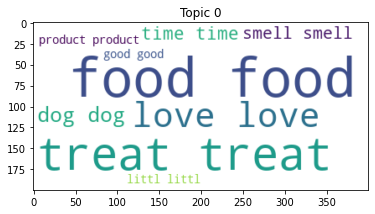

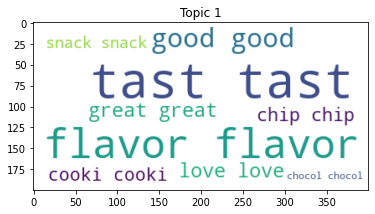

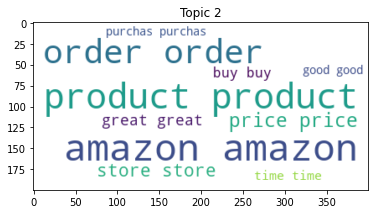

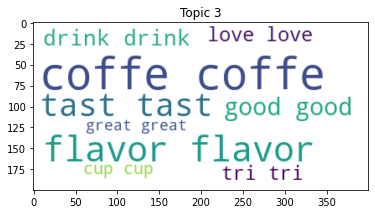

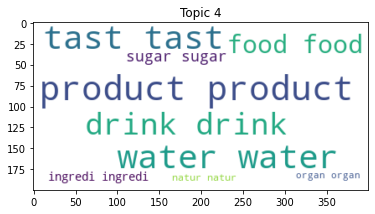

<Figure size 432x288 with 0 Axes>

In [53]:
visualise_topics(lda_model, topics)

## TF-IDF

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=topics, id2word=dictionary, passes=2, workers=4)

In [ ]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}\n'.format(idx, topic))

In [ ]:
visualise_topics(lda_model_tdidf, topics)

# Testing Models

In [ ]:
for index, score in sorted(lda_model[bow_corpus[45]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic {}: {}".format(score, index, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic {}: {}".format(score, index, lda_model_tfidf.print_topic(index, 10)))

In [ ]:
classes = []
for text in bow_corpus:
    index, score = sorted(lda_model[text], key=lambda tup: -1*tup[1])[0]
    classes.append(index)
        

# Word Embedding

In [15]:
full_text = [" ".join(doc) for doc in processed_docs]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(full_text, classes, test_size=0.20, random_state=42)
X_train[:5]

['like say instant coffe terribl instant coffe',
 'person household diabet carber love pasta week haven notic appreci rise blood glucos level negat effect carb diet product cours limit portion plenti protein veget probabl help prevent glucos insulin spike think success proport pasta protein veget essenti pasta delici high recommend',
 'best chip date march open seal tight chip open reek want explod face worri happi',
 'purchas snack dietari fiber disagre',
 'perfect fact chocol littl melet receiv chocol expect send freezer']

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
hot_y_train = keras.utils.to_categorical(y_train)
hot_y_test = keras.utils.to_categorical(y_test)

In [19]:
embeddings_dictionary = dict()
size = 200
glove_file = open('glove.6B/glove.6B.'+str(size)+'d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [20]:
embedding_matrix = np.zeros((vocab_size, size))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Sentiment Analysis

Use neural networks to predict the sentiment of bodies of text. These are across two topics which were generated using LDA.

## Visualisation

In [21]:
import itertools
def plot_confusion_matrix(cm,
                          classes,
                          title='Confusion matrix',
                          cmap=plt.get_cmap('Blues')):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy
    plt.figure(figsize=(8, 6))
    normalized = np.nan_to_num(cm / cm.sum())
    plt.imshow(normalized, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = normalized.max() / 1.5
    for i, j in itertools.product(range(normalized.shape[0]), range(normalized.shape[1])):
        plt.text(j, i, "{:0.4f}".format(normalized[i, j]),
                     horizontalalignment="center",
                     color="white" if normalized[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Dense NN

In [22]:
def single_layer(out):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, size, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Flatten())
    model.add(Dense(out, activation='softmax'))
    model.compile(optimizer='adam', loss=loss, metrics=['acc'])
    print(model.summary())
    return model

In [23]:
model = single_layer(topics)
history = model.fit(X_train, hot_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, hot_y_test, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          13472800  
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 100005    
Total params: 13,572,805
Trainable params: 100,005
Non-trainable params: 13,472,800
_________________________________________________________________
None
Epoch 1/8
5685/5685 [==============================] - 13s 2ms/step - loss: 0.6500 - acc: 0.7679 - val_loss: 0.6147 - val_acc: 0.7854
Epoch 2/8
5685/5685 [==============================] - 13s 2ms/step - loss: 0.5623 - acc: 0.7999 - val_loss: 0.6350 - val_acc: 0.7902
Epoch 3/8
5685/5685 [==============================] - 13s 2ms/step - loss: 0.5394 - acc: 0.807

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/Users/freddiebrown/Library/Python/3.7/lib/python/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0 1 2 3 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


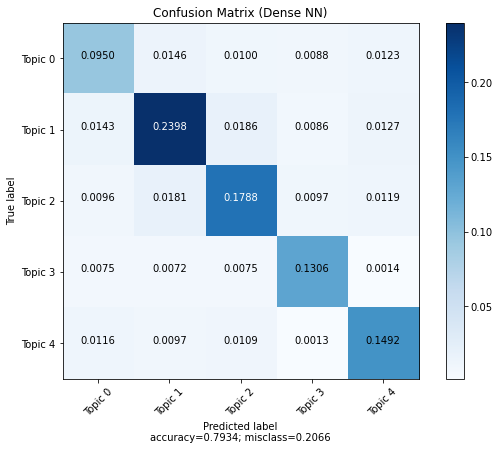

In [24]:
pred_classes = model.predict_classes(X_test)
confuse = confusion_matrix(y_test, pred_classes, np.unique(y_test))
plot_confusion_matrix(confuse, ["Topic {}".format(str(tag)) for tag in np.unique(y_test)], title="Confusion Matrix (Dense NN)")

## Convolutional NN

In [25]:
def conv_nn(out):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, size, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(out, activation='softmax'))
    model.compile(optimizer='adam', loss=loss, metrics=['acc'])
    print(model.summary())
    return model

In [26]:
model = conv_nn(topics)
history = model.fit(X_train, hot_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, hot_y_test, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          13472800  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           128128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 13,601,573
Trainable params: 128,773
Non-trainable params: 13,472,800
_________________________________________________________________
None
Epoch 1/8
5685/5685 [==============================] - 107s 19ms/step - loss: 0.4426 - acc: 0.8331 - val_loss: 0.3932 - val_acc: 0.8539
Epoch 2/8
5685/5685 [==============================] - 113s 20ms/step - loss: 0.3347 - acc: 0

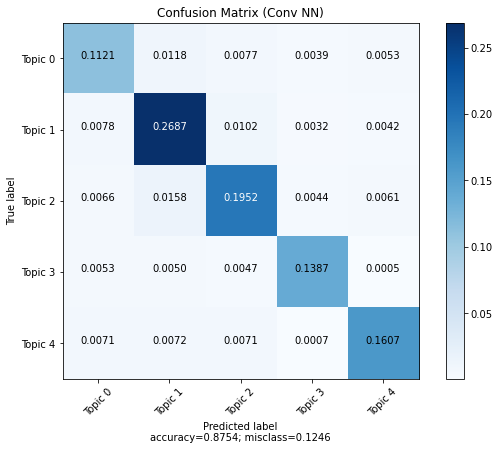

In [27]:
pred_classes = model.predict_classes(X_test)
confuse = confusion_matrix(y_test, pred_classes, np.unique(y_test))
plot_confusion_matrix(confuse, ["Topic {}".format(str(tag)) for tag in np.unique(y_test)], title="Confusion Matrix (Conv NN)")

# Deep NN

In [28]:
def deep_model(out):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, size, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(128, return_sequences=True))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.3))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(out, activation='softmax'))
    model.compile(optimizer='adam', loss=loss, metrics=['acc'])
    print(model.summary())
    return model

In [29]:
model = deep_model(topics)
history = model.fit(X_train, hot_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, hot_y_test, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          13472800  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          168448    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)               

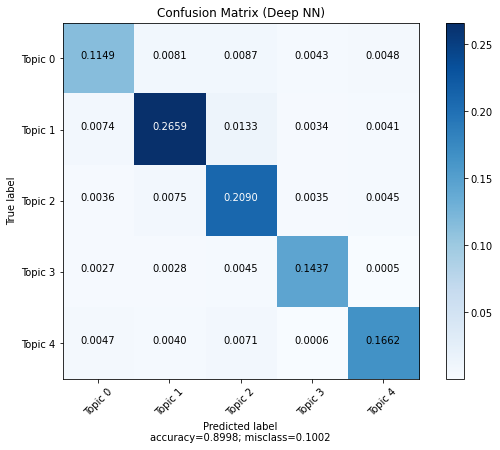

In [30]:
pred_classes = model.predict_classes(X_test)
confuse = confusion_matrix(y_test, pred_classes, np.unique(y_test))
plot_confusion_matrix(confuse, ["Topic {}".format(str(tag)) for tag in np.unique(y_test)], title="Confusion Matrix (Deep NN)")